In [1]:
import xarray as xr
import os, sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from xskillscore import crps_ensemble, crps_gaussian
module_path = '/home/jupyter-aaron/Postprocessing/PP_EUPP'
if module_path not in sys.path:
    sys.path.append(module_path)
from Transformer import StackedTransformer

In [2]:
def fair_crps_ensemble(observations, forecasts, axis=0):

    # Convert inputs to numpy arrays if they're not already
    forecasts = np.asarray(forecasts)
    observations = np.asarray(observations)
    
    if axis != 1:
        forecasts = np.moveaxis(forecasts, axis, 1)
    
    # Get number of ensemble members
    m = forecasts.shape[1]
    
    # Calculate dxy: sum of absolute differences between forecasts and observations
    # Add a dimension to observations to allow broadcasting
    observations_expanded = np.expand_dims(observations, axis=1)
    dxy = np.sum(np.abs(forecasts - observations_expanded), axis=1)
    
    # Calculate dxx: sum of absolute differences between all pairs of ensemble members
    # Add dimensions to enable broadcasting for pairwise differences
    forecast_i = np.expand_dims(forecasts, axis=2)  # [batch, ens, 1, ...]
    forecast_j = np.expand_dims(forecasts, axis=1)  # [batch, 1, ens, ...]
    dxx = np.sum(np.abs(forecast_i - forecast_j), axis=(1, 2))
    
    # Calculate CRPS using the kernel approximation formula
    crps = dxy / m - dxx / (m * (m - 1) * 2)
    
    return crps

In [3]:
test_rfcs=xr.open_dataset("/home/jupyter-aaron/Postprocessing/PP_EUPP/data/TEST/test_reforecast.nc")
obs=xr.open_dataset("/home/jupyter-aaron/Postprocessing/PP_EUPP/data/TEST/test_observation.nc")

In [4]:
test_rfcs=test_rfcs
obs=obs

In [5]:
obs=obs.sel(longitude=slice(5,10.5),latitude=slice(48.5,45.75))
#(5,10.5)-(45.75,48.5)

In [6]:
target='t2m'  
obs=obs[target]
test_rfcs=test_rfcs.drop_vars(["u100", "w100","u", "v", "w700", "v100"])
#'t2m', 'z', 't', 'u10', 'v10', 'tcc', 'sd', 'mx2t6', 'mn2t6', 'w10', 'p10fg6', 'oro'
#'t2m', 'z', 't', 'u10', 'v10', 'tcc', 'sd', 'mx2t6', 'mn2t6', 'w10', 'u100', 'w100', 'p10fg6', 'v100', 'oro'
#'t2m', 'z', 't', 'u10', 'v10', 'tcc', 'w10', 'u100', 'w100', 'u', 'w700', 'p10fg6', 'v100', 'v', 'oro'


In [7]:
#new_order = ['t2m', 't', 'u10', 'v10', 'mx2t6', 'mn2t6', 'w10', 'p10fg6']
#test_rfcs = test_rfcs[new_order]

In [8]:
#add orography as a variable
oro=xr.open_dataset("/home/jupyter-aaron/Postprocessing/PP_EUPP/data/oro.nc") 
dims={'time' : test_rfcs['time'],
       'number': test_rfcs['number'],
       'step': test_rfcs['step']}
xds_oro=oro.expand_dims(time=dims['time'], number=dims['number'],step=dims['step'])
dummy_oro=xr.Dataset(coords=dims)
final_oro=xds_oro.broadcast_like(dummy_oro)

In [9]:
fcs_10=xr.merge([test_rfcs,final_oro])
dummy=xr.merge([test_rfcs,final_oro])

In [9]:
#normalizing
min_max_values={"t2m":(235, 304), "z": (48200, 58000), "t":(240, 299), "u10": (-13., 11.),"v10": (-30,35), "tcc": (0., 1.0),"sd":(0,8),"mx2t6":(230,320),"mn2t6":(225,315),"v":(-50,55), "w100":(0,50),"w10":(0,30), "u100": (-35,45), "u": (-45,60),"v100":(-40,45), "w700": (0,60), "p10fg6": (0,60), "oro":(-400,2800)}
# Function to normalize using vectorized operations
def minmax_normalize(ds, min_max_values):
    for var in ds.data_vars:
        if var in min_max_values:
            min_val, max_val = min_max_values[var]
            ds[var] = (ds[var] - min_val) / (max_val - min_val)
    return ds

def z_normalize(ds):
    for var in ds.data_vars:
        ds[var] = ds[var].copy()  # Ensure the variable is writable
        
        for t in range(len(ds["time"])):  # Loop over time dimension
            mean = ds[var].isel(time=t).mean()
            std = ds[var].isel(time=t).std()
            ds[var].loc[dict(time=ds["time"][t])] = (ds[var].isel(time=t) - mean) / std

    return ds



#dummy_norm=minmax_normalize(dummy,min_max_values)
#fcs_norm=dummy_norm
test_rfcs = test_rfcs.sel(
    longitude=slice(5,10.5),latitude=slice(48.5,45.75)
)
#49-53,5 (2.5,7),(53,5.49)
fcs_10 = test_rfcs
dummy=test_rfcs

In [10]:
%reload_ext autoreload
model =  StackedTransformer(num_blocks=4, n_data_shape=(20, 23,12,11), n_heads=8,mlp_mult=4,projection_channels=64)

In [11]:
#this is where the last run is stored 
checkpoint_path = f'/home/jupyter-xavi/results/Transformerweights/t2m/Mepochs30predictors11CRPSlambda0.02k3.3.pth'
# Load the checkpoint
checkpoint = torch.load(checkpoint_path, weights_only=False)
model_state_dict = checkpoint['model']
new_state_dict = {k.replace("module.", ""): v for k, v in model_state_dict.items()}
model.load_state_dict(new_state_dict)
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  553313


In [12]:
print(list(test_rfcs.data_vars))

['t2m', 'z', 't', 'u10', 'v10', 'tcc', 'sd', 'mx2t6', 'mn2t6', 'w10', 'p10fg6']


In [13]:
#turn the normalized reforecasts into a tensor
#fcs_norm_whole= fcs_norm.to_array(dim='variable')
fcs_norm_whole= test_rfcs.to_array(dim='variable')
rearranged_10= fcs_norm_whole.transpose('time', 'number','step','longitude', 'latitude' , 'variable')
fcs_whole_tensor=torch.tensor(rearranged_10.values)
print(fcs_whole_tensor.shape) 

torch.Size([209, 11, 20, 23, 12, 11])


In [14]:
#same for unnormalized data, because I need them for the rescaling 
fcs_array_10 =fcs_10.to_array(dim='variable')
fcs_rearranged_10= fcs_array_10.transpose('time', 'number','step', 'longitude', 'latitude' , 'variable')
fcs_whole_notnorm_tensor=torch.tensor(fcs_rearranged_10.values)
print(fcs_whole_notnorm_tensor.shape)

torch.Size([209, 11, 20, 23, 12, 11])


In [15]:
import torch
postpro_10_whole = torch.empty((209,11,20,23,12,1))

# Apply model in chunks of 10
with torch.no_grad():
    for i in range(0, 209, 2):
        # Get the end index for this chunk
        end = min(i + 2, 209)  # Ensure we don't go out of bounds

        # Apply the model to the chunk and store in the corresponding location in postpro_10_whole
        postpro_10_whole[i:end] = model(fcs_whole_tensor[i:end])

In [16]:
print(f"Shape entering model: {fcs_whole_tensor[i:end].shape}")

Shape entering model: torch.Size([1, 11, 20, 23, 12, 11])


In [14]:
MBM_one=np.empty((209,11,20,32,33),dtype=float)
MBM_all= np.empty((209,11,20,32,33),dtype=float)
for i in range(20):
    mbm1=np.load(f"/home/jupyter-aaron/Postprocessing/PP_EUPP/ClassicalMBM/resultsClassicalMBM/t2m/MBM_t2m_{i}_pred1.npy")
    MBM_one[:,:,i,:,:]=mbm1.squeeze()
    mbm_all=np.load(f"/home/jupyter-aaron/Postprocessing/PP_EUPP/ClassicalMBM/resultsClassicalMBM/t2m/MBM_t2m_{i}_pred11.npy")
    MBM_all[:,:,i,:,:]=mbm_all.squeeze()

In [15]:
np.save("/home/jupyter-xavi/ClassicalMBM/t2m/MBM_t2m_all.npy",MBM_all)
np.save("/home/jupyter-xavi/ClassicalMBM/t2m/MBM_t2m_one.npy",MBM_one)

In [17]:
#MBM_all=np.load("/home/jupyter-xavi/ClassicalMBM/t2m/MBM_t2m_all.npy")
#MBM_one=np.load("/home/jupyter-xavi/ClassicalMBM/t2m/MBM_t2m_one.npy")
#postpro_1_whole = torch.load("postpro_1_whole_t2m_all.pt")
# = torch.load("postpro_10_whole_t2m_all.pt")
ensemble_all=postpro_10_whole[...,0]
#ensemble_one = postpro_1_whole[...,0]
values_tar = fcs_whole_notnorm_tensor[:,:,:,:,:,0] #torch.Size([26, 11, 32, 33])
scale_std, scale_mean= torch.std_mean(values_tar, dim=1, unbiased=True)
scaled_ensemble_all=(ensemble_all * scale_std.unsqueeze(1) + scale_mean.unsqueeze(1)).permute(1, 0, 2, 3, 4)
#scaled_ensemble_one=(ensemble_one * scale_std.unsqueeze(1) + scale_mean.unsqueeze(1)).permute(1, 0, 2, 3, 4)

In [18]:
# Define coordinates with member first

coords_forecast = {
    'member': test_rfcs['number'].rename({'number': 'member'}),
    'time': obs['time'],
    'step': obs['step'],
    'latitude': obs['latitude'],
    'longitude': obs['longitude'],
}    


# Define dimensions with member first
dims_forecast = ('member','time','step','longitude','latitude')

# Convert numpy arrays to xarray DataArray with the specified order
#MBM_all=xr.DataArray(np.transpose(MBM_all,(1,0,2,3,4)), coords=coords_forecast, dims=dims_forecast)
#MBM_one=xr.DataArray(np.transpose(MBM_one,(1,0,2,3,4)), coords=coords_forecast, dims=dims_forecast)
full_ensemble_all = xr.DataArray(scaled_ensemble_all, coords=coords_forecast, dims=dims_forecast)
#full_ensemble_one= xr.DataArray(scaled_ensemble_one, coords=coords_forecast, dims=dims_forecast)
# Compute mean and std across the member dimension
mean_all = full_ensemble_all.mean(dim='member')
std_all = full_ensemble_all.std(dim='member')

#mean_one = full_ensemble_one.mean(dim='member')
#std_one = full_ensemble_one.std(dim='member')

# Adjust raw_fcs to have 'member' first
raw_fcs = test_rfcs.rename({'number': 'member'})
raw_fcs = raw_fcs.transpose('member', 'time', 'step', 'latitude', 'longitude')
raw_mean=raw_fcs.mean(dim='member')
raw_std=raw_fcs.std(dim='member')

In [28]:
#ALL ENSEMBLES
Tformer_all=full_ensemble_all
#Tformer_one=full_ensemble_one
MBM_all = MBM_all
MBM_one = MBM_one
Raw = raw_fcs[target]
obs=obs.squeeze()

NameError: name 'full_ensemble_all' is not defined

In [21]:
np.save("Tformer_t2m_all.npy",Tformer_all)
#np.save("Tformer_t2m_one.npy",Tformer_one)
#np.save("Raw_t2m.npy",Raw)
np.save("obs_t2m.npy",obs)
np.save("MBM_t2m_all.npy",MBM_all)
np.save("MBM_t2m_one.npy",MBM_one)

In [26]:
import xskillscore as xs

output_dir = "/home/jupyter-xavi/plots/results/CRPS"
os.makedirs(output_dir, exist_ok=True)

# Load observations (assuming you have them)
observations = obs

# Dictionary of ensemble forecasts
ensembles = {
    "Tformer_all": Tformer_all,
    #"Tformer_one": Tformer_one,
    "MBM_all": MBM_all,
    "MBM_one": MBM_one,
    #"Raw": raw_fcs
}

# Process each ensemble
for name, ensemble in ensembles.items():
    print(f"Processing {name}...")
    
    obs_broadcast = observations
    
    # Initialize arrays to store CRPS values
    # Assuming we compute CRPS for each leadtime
    n_leadtimes = ensemble.shape[2]
    # gaussian_crps = np.zeros(n_leadtimes)
    fair_crps = np.zeros(n_leadtimes)
    
    # Compute CRPS for each leadtime
    for lt in range(n_leadtimes):
        
        # Extract data for this leadtime
        ensemble_lt = ensemble[:, :, lt, :, :]  # (member, time, lat, lon)
        obs_lt = obs_broadcast[:, lt, :, :]  # (time, lat, lon)
        
        # Convert to xarray for xs.crps_gaussian
        ensemble_xr = xr.DataArray(
            ensemble_lt, 
            dims=["member", "time", "latitude", "longitude"]
        )
        obs_xr = xr.DataArray(
            obs_lt,
            dims=["time", "latitude", "longitude"]
        )
        
        # Compute Gaussian CRPS
        # Mean and standard deviation along member dimension
        mean = ensemble_xr.mean(dim="member")
        std = ensemble_xr.std(dim="member")
        g_crps = xs.crps_gaussian(obs_xr, mean, std)
        gaussian_crps[lt] = g_crps.mean().values
        
        # Compute fair ensemble CRPS
        f_crps = fair_crps_ensemble(obs_lt, ensemble_lt, axis=0)
        fair_crps[lt] = np.mean(f_crps)
    
    # Save results
    np.save(f"{output_dir}/{name}_gaussian_crps.npy", gaussian_crps)
    np.save(f"{output_dir}/{name}_fair_crps.npy", fair_crps)
    

print("All CRPS computations complete!")

Processing Tformer_all...


NameError: name 'gaussian_crps' is not defined

In [27]:
np.load("/home/jupyter-xavi/plots/results/CRPS/Tformer_all_gaussian_crps.npy")

array([0.82372476, 0.8716863 , 0.90376303, 0.84025408, 0.7939933 ,
       0.94190973, 1.00840998, 0.90117958, 0.86828234, 1.02376738,
       1.05081809, 1.01753307, 1.0286384 , 1.21875732, 1.2257253 ,
       1.151617  , 1.14103532, 1.35621365, 1.32640477, 1.25985259])

In [28]:
CRPS_TF = np.load("/home/jupyter-xavi/plots/results/CRPS/Tformer_all_fair_crps.npy")
CRPS_TF_1 = np.load("/home/jupyter-xavi/plots/results/CRPS/Tformer_all_fair_crps.npy")
CRPS_TF_G = np.load("/home/jupyter-xavi/plots/results/CRPS/Tformer_all_fair_crps.npy")
CRPS_TF_1_G = np.load("/home/jupyter-xavi/plots/results/CRPS/Tformer_all_fair_crps.npy")
CRPS_MBM = np.load("/home/jupyter-xavi/plots/results/CRPS/Tformer_all_fair_crps.npy")
CRPS_MBM_1 = np.load("/home/jupyter-xavi/plots/results/CRPS/Tformer_all_fair_crps.npy")
CRPS_MBM_G = np.load("/home/jupyter-xavi/plots/results/CRPS/Tformer_all_fair_crps.npy")
CRPS_MBM_1_G = np.load("/home/jupyter-xavi/plots/results/CRPS/Tformer_all_fair_crps.npy")
#CRPS_OG=np.load("./CRPS/Raw_fair_crps.npy")
#CRPS_OG_G=np.load("./CRPS/Raw_gaussian_crps.npy")
#meanOG=np.mean(CRPS_OG)
#meanOG_g=np.mean(CRPS_OG_G)
meanmbm= np.mean(CRPS_MBM)
meanmbm_1=np.mean(CRPS_MBM_1)
meanmbm_g =np.mean(CRPS_MBM_G)
meanmbm_1_g=np.mean(CRPS_MBM_1_G)
meantf=np.mean(CRPS_TF)
meantf_1=np.mean(CRPS_TF_1)
meantf_g = np.mean(CRPS_TF_G)
meantf_1_g=np.mean(CRPS_TF_1_G)
print(meanmbm,meanmbm_1,meanmbm_g,meanmbm_1_g,meantf,meantf_1,meantf_g,meantf_1_g) #meanOG,meanOG_g

1.0291913190839954 1.0291913190839954 1.0291913190839954 1.0291913190839954 1.0291913190839954 1.0291913190839954 1.0291913190839954 1.0291913190839954


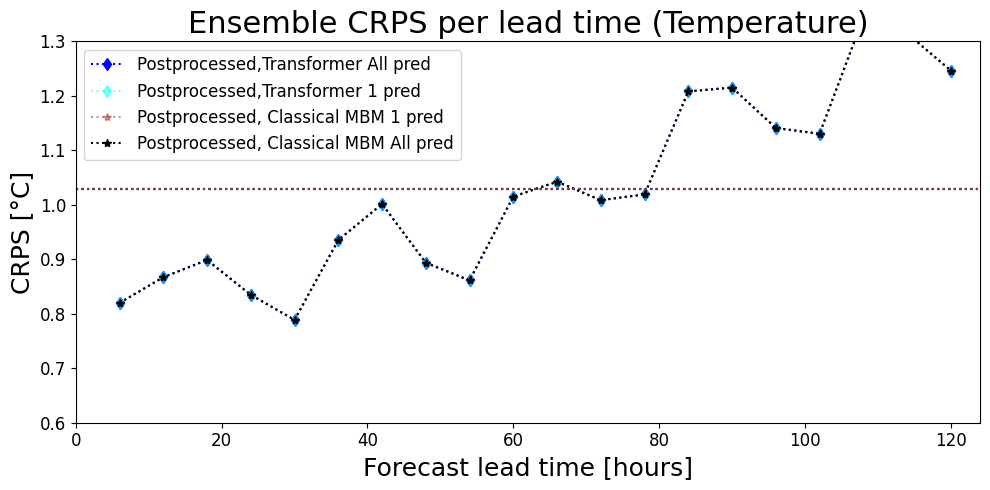

In [29]:
#CRPS WITHOUT GAUSSIAN ASSUMPTION
Leadtimes=obs.step.values
matplotlib.rcParams['text.usetex'] = False
plt.figure(figsize=(10, 5))
#plt.plot(Leadtimes, CRPS_OG, color='red', marker='o', label='Original')
plt.plot(Leadtimes, CRPS_TF, color='blue',linestyle=':', marker='d' ,label='Postprocessed,Transformer All pred')
plt.plot(Leadtimes, CRPS_TF_1, color='cyan',linestyle=':', marker='d' ,alpha=0.5,label='Postprocessed,Transformer 1 pred')
plt.plot(Leadtimes, CRPS_MBM_1, color='brown',linestyle=':', marker='*',alpha=0.5, label='Postprocessed, Classical MBM 1 pred')
plt.plot(Leadtimes, CRPS_MBM, color='black',linestyle=':', marker='*', label='Postprocessed, Classical MBM All pred')


#plt.axhline(y=meanOG, color='red',linestyle=':')
plt.axhline(y=meantf, color='blue',linestyle=':')
plt.axhline(y=meantf_1, color='cyan',linestyle=':')
plt.axhline(y=meanmbm, color='black',linestyle=':')
plt.axhline(y=meanmbm_1, color='brown',linestyle=':')

# Set title and labels
plt.title('Ensemble CRPS per lead time (Temperature)', fontsize=22)
plt.xlabel('Forecast lead time [hours]', fontsize=18)
plt.ylabel('CRPS [°C]', fontsize=18)

# Set y-axis limits and x-axis ticks
plt.xlim(0,124)
plt.ylim(0.6,1.3)

# Set tick label size and show legend
plt.tick_params(axis='both', labelsize=12)
plt.legend(fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()
#plt.savefig("CRPS_leadtime_all.png")
plt.show()

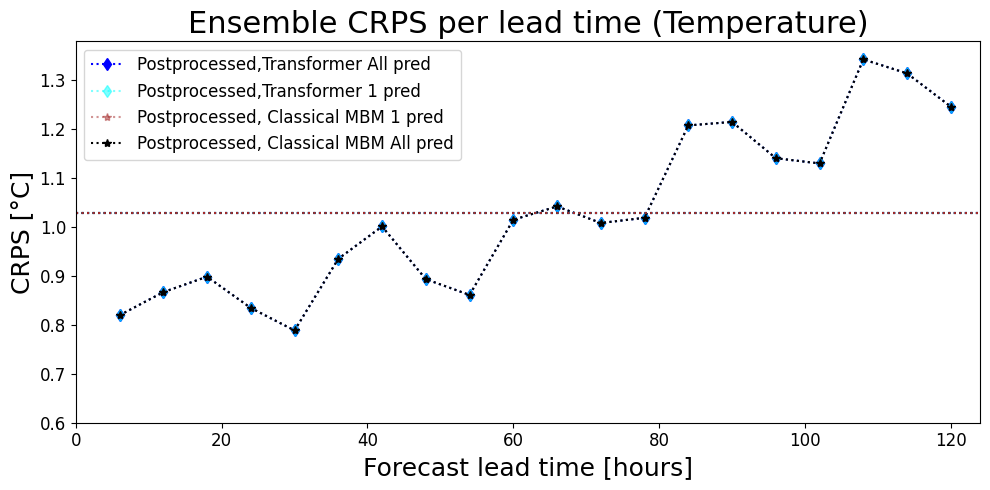

In [30]:
#CPRS WITH GAUSSIAN ASSUMPTION
matplotlib.rcParams['text.usetex'] = False
plt.figure(figsize=(10, 5))
#plt.plot(Leadtimes, CRPS_OG_G, color='red', marker='o', label='Original')
plt.plot(Leadtimes, CRPS_TF_G, color='blue',linestyle=':', marker='d' ,label='Postprocessed,Transformer All pred')
plt.plot(Leadtimes, CRPS_TF_1_G, color='cyan',linestyle=':', marker='d' ,alpha=0.5,label='Postprocessed,Transformer 1 pred')
plt.plot(Leadtimes, CRPS_MBM_1_G, color='brown',linestyle=':', marker='*',alpha=0.5, label='Postprocessed, Classical MBM 1 pred')
plt.plot(Leadtimes, CRPS_MBM_G, color='black',linestyle=':', marker='*', label='Postprocessed, Classical MBM All pred')


#plt.axhline(y=meanOG_g, color='red',linestyle=':')
plt.axhline(y=meantf_g, color='blue',linestyle=':')
plt.axhline(y=meantf_1_g, color='cyan',linestyle=':')
plt.axhline(y=meanmbm_g, color='black',linestyle=':')
plt.axhline(y=meanmbm_1_g, color='brown',linestyle=':')

# Set title and labels
plt.title('Ensemble CRPS per lead time (Temperature)', fontsize=22)
plt.xlabel('Forecast lead time [hours]', fontsize=18)
plt.ylabel('CRPS [°C]', fontsize=18)

# Set y-axis limits and x-axis ticks
plt.xlim(0,124)
plt.ylim(0.6,1.38)

# Set tick label size and show legend
plt.tick_params(axis='both', labelsize=12)
plt.legend(fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()
#plt.savefig("CRPS_leadtime_all.png")
plt.show()

In [31]:
#Example of an ensemble
np.random.seed(156)  # For reproducibility #156
random_time = np.random.randint(0, Tformer_all.sizes["time"])
random_lat = np.random.randint(0, Tformer_all.sizes["latitude"])
random_lon = np.random.randint(0, Tformer_all.sizes["longitude"])

# Extract data for all 11 ensemble members at the chosen location
TF = Tformer_all[:, random_time, :, random_lat, random_lon]  # Shape: (11, step)
MBM = MBM_all[:, random_time, :, random_lat, random_lon]  # Shape: (11, step)
OBS = obs[random_time, :, random_lat, random_lon] 
RAW = raw_fcs[:, random_time, :, random_lat, random_lon]  # Shape: (11, step)
# Plot all ensemble members as a function of step
plt.figure(figsize=(10, 6))
#plt.plot(MBM_all.step, np.mean(RAW,axis=0),color='red',alpha=0.8,label="Raw Forecasts")
plt.plot(MBM_all.step, np.mean(MBM,axis=0),color='black',alpha=0.8,label="Classical MBM")
plt.plot(Tformer_all.step, np.mean(TF,axis=0),color='blue',alpha=0.8,label="Transformer")
plt.plot(MBM_all.step, OBS,color='green',alpha=0.8,label="Observations")
for member in range(TF.sizes["member"]):
    plt.plot(Tformer_all.step, TF[member, :],color='blue',alpha=0.2)
    plt.plot(MBM_all.step, MBM[member, :],color='black',alpha=0.2)
    #plt.plot(raw_fcs.step, RAW[member,:],color='red',alpha=0.2)

# Formatting the plot
plt.xlabel("Timestep, ")
plt.ylabel("Temperature")
plt.title("Temperature, randomly selected day",fontsize="20")
plt.legend(loc="upper right", fontsize=12, ncol=2)
plt.grid(True)
plt.show()

ValueError: Unsupported key-type <class 'tuple'>

In [19]:
ensemble_all=postpro_10_whole[...,0]
tf_mu=torch.mean(ensemble_all,axis=1)
tf_std=torch.std(ensemble_all,axis=1)
tf_mu=tf_mu*scale_std + scale_mean
tf_std=torch.exp(tf_std)*scale_std
#MBM_mu=np.mean(MBM_all,axis=1)
#MBM_std=np.std(MBM_all,axis=1)

In [20]:
coords_forecast = {
    'time': obs['time'],  # time dimension
    'step':obs['step'],
    'latitude': obs['latitude'],  # Latitude dimension
    'longitude':obs['longitude'],  # Longitude dimension
}
dims_forecast = ('time','step','longitude',  'latitude' )  # Dimensions in order


In [21]:
tf_mu = xr.DataArray(tf_mu, coords=coords_forecast, dims=dims_forecast)
tf_std =xr.DataArray(tf_std, coords=coords_forecast, dims=dims_forecast)
#MBM_mu = xr.DataArray(MBM_mu, coords=coords_forecast, dims=dims_forecast)
#MBM_std =xr.DataArray(MBM_std, coords=coords_forecast, dims=dims_forecast)

In [22]:
np.save("TF_mu.npy", tf_mu)
np.save("TF_std.npy",tf_std)

In [23]:
Leadtimes=list(fcs_10.step.values)
CRPS_OG=[]
CRPS_TF=[]
CRPS_MBM=[]
for i in range(len(fcs_10.step)):
    mu_OG=fcs_rearranged_10.isel(step=i).sel(variable='w10').mean(dim='number')
    sigma_OG=fcs_rearranged_10.isel(step=i).sel(variable='w10').std(dim='number')
    mu_postpro=tf_mu.isel(step=i)
    sigma_postpro= tf_std.isel(step=i)
    CRPS_P = crps_gaussian(obs.isel(step=i),mu_postpro,sigma_postpro).values
    CRPS_O = crps_gaussian(obs.isel(step=i),mu_OG,sigma_OG).values
    CRPS_OG.append(CRPS_O.item())
    CRPS_TF.append(CRPS_P.item())
    #mu_MBM=MBM_mu.isel(step=i)
    #sigma_MBM= MBM_std.isel(step=i)
    #CRPS_M = crps_gaussian(obs.isel(step=i),mu_MBM,sigma_MBM).values
    #CRPS_MBM.append(CRPS_M.item()##)

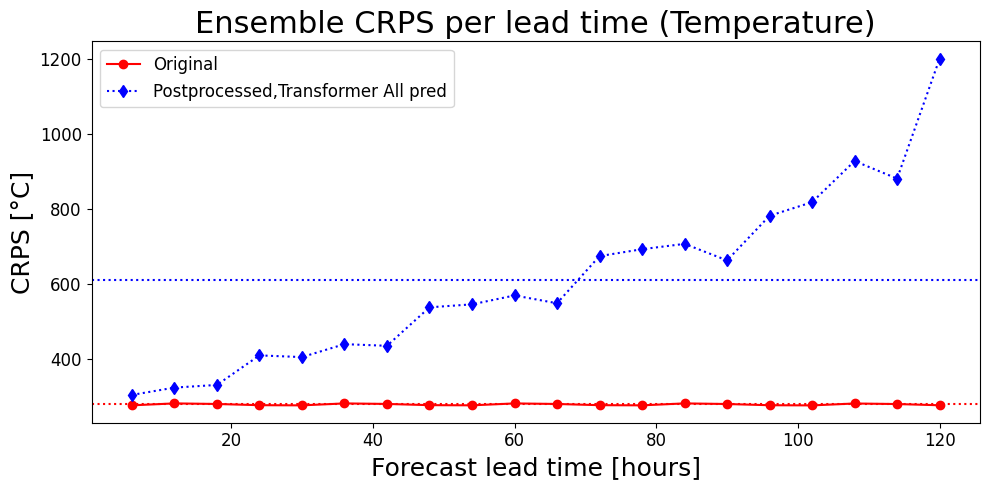

In [24]:
#CPRS WITH GAUSSIAN ASSUMPTION
matplotlib.rcParams['text.usetex'] = False
plt.figure(figsize=(10, 5))
plt.plot(Leadtimes, CRPS_OG, color='red', marker='o', label='Original')
plt.plot(Leadtimes, CRPS_TF, color='blue',linestyle=':', marker='d' ,label='Postprocessed,Transformer All pred')
#plt.plot(Leadtimes, CRPS_MBM, color='black',linestyle=':', marker='*', label='Postprocessed, Classical MBM All pred')


plt.axhline(y=np.mean(CRPS_OG), color='red',linestyle=':')
plt.axhline(y=np.mean(CRPS_TF), color='blue',linestyle=':')
#plt.axhline(y=np.mean(CRPS_MBM), color='black',linestyle=':')

# Set title and labels
plt.title('Ensemble CRPS per lead time (Temperature)', fontsize=22)
plt.xlabel('Forecast lead time [hours]', fontsize=18)
plt.ylabel('CRPS [°C]', fontsize=18)

# Set y-axis limits and x-axis ticks
#plt.xlim(0,124)
#plt.ylim(0.6,1.38)

# Set tick label size and show legend
plt.tick_params(axis='both', labelsize=12)
plt.legend(fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()
#plt.savefig("CRPS_leadtime_all.png")
plt.show()

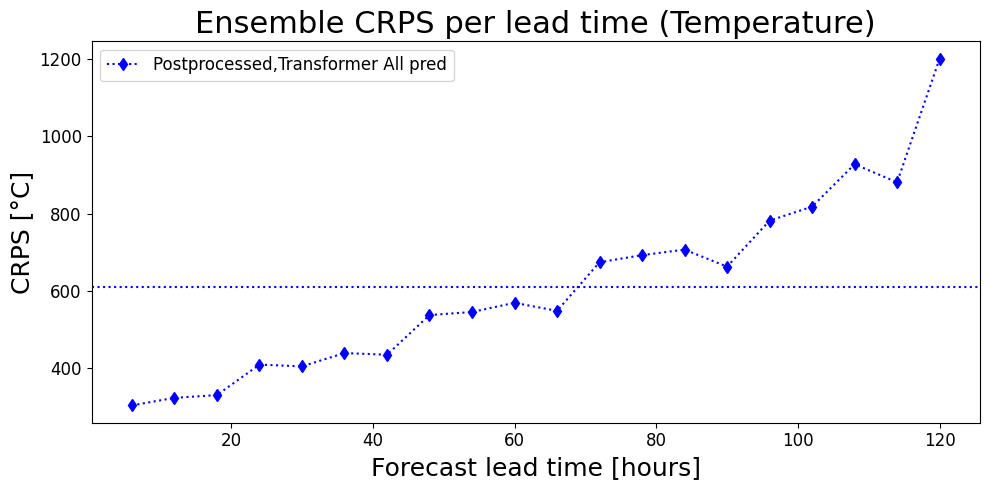

In [25]:
#CPRS WITH GAUSSIAN ASSUMPTION
matplotlib.rcParams['text.usetex'] = False
plt.figure(figsize=(10, 5))
#plt.plot(Leadtimes, CRPS_OG, color='red', marker='o', label='Original')
plt.plot(Leadtimes, CRPS_TF, color='blue',linestyle=':', marker='d' ,label='Postprocessed,Transformer All pred')



#plt.axhline(y=np.mean(CRPS_OG), color='red',linestyle=':')
plt.axhline(y=np.mean(CRPS_TF), color='blue',linestyle=':')


# Set title and labels
plt.title('Ensemble CRPS per lead time (Temperature)', fontsize=22)
plt.xlabel('Forecast lead time [hours]', fontsize=18)
plt.ylabel('CRPS [°C]', fontsize=18)

# Set y-axis limits and x-axis ticks
#plt.xlim(0,124)
#plt.ylim(0.6,1.38)

# Set tick label size and show legend
plt.tick_params(axis='both', labelsize=12)
plt.legend(fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()
#plt.savefig("CRPS_leadtime_all.png")
plt.show()